In [1]:
from keras.layers import Input, merge, Concatenate, Dense, Dropout, Conv2D, Add, Dot, Lambda, Conv2DTranspose, Dot, Activation, Reshape, BatchNormalization, UpSampling2D, AveragePooling2D, GlobalAveragePooling2D, Multiply, LeakyReLU, Flatten, MaxPool2D 
from keras.layers.convolutional import Convolution2D, UpSampling2D
from keras.models import Model
import keras.backend as K
import tensorflow as tf

Using TensorFlow backend.


In [2]:
# Author: Jose Sepulveda
# Description: This is a keras implementation of spectral normalization.
#              This was proposed in this paper: https://arxiv.org/pdf/1802.05957.pdf
#


from keras import backend as K


# Stochastic Gradient Descent with Spectral Normalization:
#   1) Initialize a random vector u, initialized from an isotropic distribution.
#   2) Use the Power iteration method with this vector u on the matrix of wieghts
#      to obtain two approximations of eigenvectors.
#   3) Calculate the spectral norm of the wieghts matrix.
#   4) Update wieghts using vanilla SGD using the spectral norm of the wieghts matrix.

def spectral_norm(w):
    """
        Input: tensor of wieghts
        Output: SN tensor of wieghts
    """
    def l2_norm(v):
        return K.sum(v ** 2) ** 0.5

    w_dim = w.shape.as_list()[-1]
    # Initialize random vector u
    u = K.random_normal(shape=[1, w_dim])

    # We need to flatten the wieghts
    w_flat = K.reshape(w, [-1, w_dim])

    # Power iteration method
    v = K.dot(u, K.transpose(w_flat))
    v = v / l2_norm(v)
    u = K.dot(v, w_flat)
    u = u / l2_norm(u)

    # Calculate the SN of W
    sigma = K.dot(K.dot(v, w_flat), K.transpose(u))
    w_sn = w_flat / sigma

    # Update wieghts
    w_sn = K.reshape(w_sn, w.shape.as_list())
    return w_sn


In [3]:
def ResBlockDown(input_shape, channel_size, channel_multiplier=1, name=None):
    # Resblock architecture
    # 1 BatchNorm 
    # 2 ReLU activation
    # 3 Conv layer
    # 4 BatchNorm
    # 5 ReLU activation
    # 6 Conv layer
    # 7 Sum with input 
    
    #FIRST BLOCK
    #input layer
    input_layer = Input(shape=input_shape)
    
    
    
    # Convolution size 3 filter as per paper
    # Need to spectrally normalize here somehow
    resblock = Conv2D(channel_size * channel_multiplier, 3, padding='same', strides=2)(input_layer)
    # BatchNorm - needs to be conditional
    resblock = BatchNormalization()(resblock)
    
    # Relu
    resblock = Activation('relu')(resblock)
    
    #SECOND BLOCK
    
   
    # Convolution size 3 filter as per paper
    # Need to spectrally normalize here somehow
    resblock = Conv2D(channel_size * channel_multiplier, 3, padding='same')(resblock)
     # BatchNorm - needs to be conditional
    resblock = BatchNormalization()(resblock)
    # Relu
    resblock = Activation('relu')(resblock)
    
    # Downsample
    #resblock = AveragePooling2D()(resblock)
    
    # Time for the shortcut connection!
    
    shortcut_identity = Conv2D(channel_size * channel_multiplier, 3, padding='same', strides=2)(input_layer)
    #shortcut_identity = AveragePooling2D()(shortcut_identity)
    
    output_layer = Add()([shortcut_identity, resblock])
    output_layer = LeakyReLU(alpha=0.2)(output_layer)
    
    return Model(input_layer, output_layer, name=name)
    





In [4]:
def ResBlockUp(input_shape, channel_size, channel_multiplier=1, name=None):
    # Resblock architecture
    # 1 BatchNorm 
    # 2 ReLU activation
    # 3 Conv layer
    # 4 BatchNorm
    # 5 ReLU activation
    # 6 Conv layer
    # 7 Sum with input 
    
    #FIRST BLOCK
    #input layer
    input_layer = Input(shape=input_shape)
    
    
    
    # Convolution size 3 filter as per paper
    # Need to spectrally normalize here somehow
    resblock = Conv2DTranspose(channel_size * channel_multiplier, 3, padding='same', strides=2)(input_layer)
    # BatchNorm - needs to be conditional
    resblock = BatchNormalization()(resblock)
    
    # Relu
    resblock = Activation('relu')(resblock)
    #SECOND BLOCK
    
    
    # Convolution size 3 filter as per paper
    # Need to spectrally normalize here somehow
    resblock = Conv2DTranspose(channel_size * channel_multiplier, 3, padding='same')(resblock)
    # BatchNorm - needs to be conditional
    resblock = BatchNormalization()(resblock)
    
    # Relu
    resblock = Activation('relu')(resblock)
    
    # Downsample
    #resblock = AveragePooling2D()(resblock)
    
    # Time for the shortcut connection!
    
    shortcut_identity = Conv2DTranspose(channel_size * channel_multiplier, 1, padding='same', strides=2)(input_layer)
    #shortcut_identity = AveragePooling2D()(shortcut_identity)
    output_layer = Add()([shortcut_identity, resblock])
    output_layer = LeakyReLU(alpha=0.2)(output_layer)
    
    return Model(input_layer, output_layer, name=name)
    
    

In [5]:
def ResBlock(input_shape, channel_size, channel_multiplier=1, name=None):
     # Resblock architecture
    # 1 BatchNorm 
    # 2 ReLU activation
    # 3 Conv layer
    # 4 BatchNorm
    # 5 ReLU activation
    # 6 Conv layer
    # 7 Sum with input 
    
    #FIRST BLOCK
    #input layer
    input_layer = Input(shape=input_shape)
    
    
    # Convolution size 3 filter as per paper
    # Need to spectrally normalize here somehow
    resblock = Conv2D(channel_size * channel_multiplier, 3, padding='same')(input_layer)
    # BatchNorm - needs to be conditional
    resblock = BatchNormalization()(resblock) 
    # Relu
    resblock = Activation('relu')(resblock)
    #SECOND BLOCK   
    
    # Convolution size 3 filter as per paper
    # Need to spectrally normalize here somehow
    resblock = Conv2D(channel_size * channel_multiplier, 3, padding='same')(resblock)
    # BatchNorm - needs to be conditional
    resblock = BatchNormalization()(input_layer)    
    # Relu
    resblock = Activation('relu')(resblock)    
    # Time for the shortcut connection!   
    shortcut_identity = Conv2D(channel_size * channel_multiplier, 1, padding='same')(input_layer)
    output_layer = Add()([shortcut_identity, resblock])
    output_layer = LeakyReLU(alpha=0.2)(output_layer)
    
    return Model(input_layer, output_layer, name=name)
    
    
    
    
    
    

In [6]:


def SelfAttentionBlock(input_shape, name=None):
    # f = conv
    channels = input_shape[-1]
    input_layer = Input(shape=input_shape)
    f = Conv2D(channels // 8, 1, padding='same')(input_layer)
    # f = maxpooling
    f = MaxPool2D(pool_size=2, strides=2, padding='same')(f)
    
    g = Conv2D(channels // 8, 1, padding='same')(input_layer)
    
    h = Conv2D(channels // 2, 1, padding='same')(input_layer)
    h = MaxPool2D(pool_size=2, strides=2, padding='same')(h)
    
    
    g = Reshape((-1, g.shape[-1]))(g)
    f = Reshape((-1, g.shape[-1]))(f)
    s = Dot(-1)([g, f])
    print("Shape of s:{}".format(s.shape))
    beta = Activation('softmax')(s)
    print("Shape of beta:{}".format(beta.shape))
    h = Reshape((-1, h.shape[-1]))(h)
    print("Shape of h:{}".format(h.shape))
    o = tf.matmul(beta, h)
    
    gamma = Conv2D(channels, (1, 1), padding='same', use_bias=False, kernel_initializer='he_normal')(input_layer)
    #gamma = Reshape((-1, channels // 2))(g)
    #print(gamma.shape)
    a, x, y ,z = input_layer.shape
    print(o.shape)
    #o = K.reshape(o, shape=[x,y,z, channels // 2])
    o = Reshape((-1,z,channels//2))(o)
    o = Conv2D(channels, kernel_size=1, strides=1)(o)
  
    Wz_yi = gamma * o
    output_layer = Add()([Wz_yi, input_layer])
    #output_layer = gamma*o + input_layer
    
    return Model(input_layer, output_layer, name=name)

In [7]:

def GlobalSumPooling2D(name=None):
    return Lambda(lambda inputs: K.sum(inputs, axis=[1, 2]), name=name)
        
# Discriminator test
def build_discriminator(channel_multiplier=64):
    input_shape = (128,128,3)
    model_input = Input(shape=input_shape, name="D_input")
    resblockdown1 = ResBlockDown(input_shape=input_shape,channel_size=1, channel_multiplier=channel_multiplier, name='D_resblock_down_1')
    h = resblockdown1(model_input)
#     selfattentionblock = SelfAttentionBlock(input_shape=(64,64,32), name='D_self_attention_block')
#     h = selfattentionblock(h)
    # Non local block should be here
    #print(h.shape)
    ch = channel_multiplier
    x = input_shape[0]
    y = input_shape[1]
    resblockdown2 = ResBlockDown(input_shape=(x,y,channel_multiplier),channel_size=2, channel_multiplier=channel_multiplier, name='D_resblock_down_2')
    h = resblockdown2(h)
    #print(h.shape)
    x = x // 2
    y = y // 2
    ch = ch * 2
    resblockdown4 = ResBlockDown(input_shape=(x,y,ch),channel_size=4, channel_multiplier=channel_multiplier, name='D_resblock_down_4')
    h = resblockdown4(h)
    x = x // 2
    y = y // 2
    ch = ch * 2
    #print(h.shape)
    resblockdown8 = ResBlockDown(input_shape=(x,y,ch),channel_size=8, channel_multiplier=channel_multiplier, name='D_resblock_down_8')
    
    h = resblockdown8(h)
    x = x // 2
    y = y // 2
    ch = ch * 2
    

    resblockdown16 = ResBlockDown(input_shape=(x,y,ch),channel_size=16, channel_multiplier=channel_multiplier, name='D_resblock_down_16')
    h = resblockdown16(h)
    x = x // 2
    y = y // 2
    ch = ch * 2
    resblock16 = ResBlock(input_shape=(x,y,ch),channel_size=16, channel_multiplier=channel_multiplier, name='D_resblock_16')
    h = resblock16(h)

    h = Activation('relu', name="D_relu")(h)
    
    h = GlobalAveragePooling2D(name="D_global_avg_pooling_2D")(h)
    #h = Dropout(0.2)(h) #added after 6th attempt
    model_output = Dense(1, name="D_dense")(h)
    model_output = LeakyReLU(alpha=0.2)(model_output) 
    #model_output = Activation("sigmoid")(model_output)
    model = Model(model_input, model_output, name="Discriminator")
    return model


In [8]:
# only noise, non conditional
def build_generator(channel_multiplier=64):

    model_input = Input(shape=(128,), name="G_input")
    h = Dense(4*4*16*channel_multiplier, name="G_dense")(model_input)
    h = Reshape((4,4,16*channel_multiplier))(h) # 512 = 16*ch
    resblockup16 = ResBlockUp(input_shape=(4,4,1024), channel_size=16, channel_multiplier=channel_multiplier, name="G_resblock_up_16")
    h = resblockup16(h)
    resblockup8 = ResBlockUp(input_shape=(8,8,1024), channel_size=8, channel_multiplier=channel_multiplier, name="G_resblock_up_8")
    h = resblockup8(h)
    resblockup4 = ResBlockUp(input_shape=(16,16,512), channel_size=4, channel_multiplier=channel_multiplier, name="G_resblock_up_4")
    h = resblockup4(h)

    resblockup2 = ResBlockUp(input_shape=(64,64,256), channel_size=2, channel_multiplier=channel_multiplier, name="G_resblock_up_2")
    h = resblockup2(h)
#     need to debug the following
    #selfattentionblock = SelfAttentionBlock(input_shape=(64,64,32), name='G_self_attention_block')
    #h = selfattentionblock(h)
    resblockup1 = ResBlockUp(input_shape=(128,128,128), channel_size=1, channel_multiplier=channel_multiplier, name="G_resblock_up_1")
    h = resblockup1(h)
    #print(h.shape)
    h = BatchNormalization()(h)
    h = Activation('relu')(h)
    model_output = Conv2D(3, kernel_size=3, strides=1, padding='same', activation='tanh')(h)
    
    return Model(model_input, model_output, name="Generator")

In [9]:
def UNETGenerator(input_img_dim, num_output_channels):
    """
    Creates the generator according to the specs in the paper below.
    It's basically a skip layer AutoEncoder
    Generator does the following:
    1. Takes in an image
    2. Generates an image from this image
    Differs from a standard GAN because the image isn't random.
    This model tries to learn a mapping from a suboptimal image to an optimal image.
    [https://arxiv.org/pdf/1611.07004v1.pdf][5. Appendix]
    :param input_img_dim: (channel, height, width)
    :param output_img_dim: (channel, height, width)
    :return:
    """
    # -------------------------------
    # ENCODER
    # C64-C128-C256-C512-C512-C512-C512-C512
    # 1 layer block = Conv - BN - LeakyRelu
    # -------------------------------
    stride = 2
    merge_mode = 'concat'

    # batch norm mode
    bn_mode = 2

    # batch norm merge axis
    bn_axis = 1

    input_layer = Input(shape=input_img_dim, name="unet_input")

    # 1 encoder C64
    # skip batchnorm on this layer on purpose (from paper)
    en_1 = Conv2D(64, 4, strides=2, padding="same")(input_layer)
    en_1 = LeakyReLU(alpha=0.2)(en_1)
    #print(en_1.shape)

    # 2 encoder C128
    en_2 = Conv2D(128, 4, strides=2,padding='same')(en_1)
    en_2 = BatchNormalization()(en_2)
    en_2 = LeakyReLU(alpha=0.2)(en_2)
    #print(en_2.shape)

    # 3 encoder C256
    en_3 = Conv2D(256, 4, padding='same', strides=2)(en_2)
    en_3 = BatchNormalization()(en_3)
    en_3 = LeakyReLU(alpha=0.2)(en_3)
    #print(en_3.shape)

    # 4 encoder C512
    en_4 = Conv2D(512, 4, padding='same', strides=2)(en_3)
    en_4 = BatchNormalization()(en_4)
    en_4 = LeakyReLU(alpha=0.2)(en_4)
   # print(en_4.shape)

    # 5 encoder C512
    en_5 = Conv2D(512, 4, padding='same', strides=2)(en_4)
    en_5 = BatchNormalization()(en_5)
    en_5 = LeakyReLU(alpha=0.2)(en_5)
    #print(en_5.shape)

    # 6 encoder C512
    en_6 = Conv2D(512, 4, padding='same', strides=2)(en_5)
    en_6 = BatchNormalization()(en_6)
    en_6 = LeakyReLU(alpha=0.2)(en_6)
   #print(en_6.shape)

    # 7 encoder C512
    en_7 = Conv2D(512, 4, padding='same', strides=2)(en_6)
    en_7 = BatchNormalization()(en_7)
    en_7 = LeakyReLU(alpha=0.2)(en_7)
    #print(en_7.shape)



    # -------------------------------
    # DECODER
    # CD512-CD1024-CD1024-C1024-C1024-C512-C256-C128
    # 1 layer block = Conv - Upsample - BN - DO - Relu
    # also adds skip connections (merge). Takes input from previous layer matching encoder layer
    # -------------------------------


    # 2 decoder CD1024 (decodes en_7)
    de_2 = UpSampling2D(size=(2, 2))(en_7)
    de_2 = Conv2D(1024, 4, padding='same')(de_2)
    de_2 = BatchNormalization()(de_2)
    de_2 = Dropout(rate=0.5)(de_2)
    de_2 = Concatenate()([de_2, en_6])
    de_2 = Activation('relu')(de_2)

    # 3 decoder CD1024 (decodes en_6)
    de_3 = UpSampling2D(size=(2, 2))(de_2)
    de_3 = Conv2D(1024, 4, padding='same')(de_3)
    de_3 = BatchNormalization()(de_3)
    de_3 = Dropout(rate=0.5)(de_3)
    de_3 = Concatenate()([de_3, en_5])
    de_3 = Activation('relu')(de_3)

    # 4 decoder CD1024 (decodes en_5)
    de_4 = UpSampling2D(size=(2, 2))(de_3)
    de_4 = Conv2D(1024, 4, padding='same')(de_4)
    de_4 = BatchNormalization()(de_4)
    de_4 = Dropout(rate=0.5)(de_4)
    de_4 = Concatenate()([de_4, en_4])
    de_4 = Activation('relu')(de_4)

    # 5 decoder CD1024 (decodes en_4)
    de_5 = UpSampling2D(size=(2, 2))(de_4)
    de_5 = Conv2D(1024, 4, padding='same')(de_5)
    de_5 = BatchNormalization()(de_5)
    de_5 = Dropout(rate=0.5)(de_5)
    de_5 = Concatenate()([de_5, en_3])
    de_5 = Activation('relu')(de_5)

    # 6 decoder C512 (decodes en_3)
    de_6 = UpSampling2D(size=(2, 2))(de_5)
    de_6 = Conv2D(512, 4, padding='same')(de_6)
    de_6 = BatchNormalization()(de_6)
    de_6 = Dropout(rate=0.5)(de_6)
    de_6 = Concatenate()([de_6, en_2])
    de_6 = Activation('relu')(de_6)

    # 7 decoder CD256 (decodes en_2)
    de_7 = UpSampling2D(size=(2, 2))(de_6)
    de_7 = Conv2D(256, 4, padding='same')(de_7)
    de_7 = BatchNormalization()(de_7)
    de_7 = Dropout(rate=0.5)(de_7)
    de_7 = Concatenate()([de_7, en_1])
    de_7 = Activation('relu')(de_7)

    # After the last layer in the decoder, a conv is applied
    # to map to the number of output channels (3 in general,
    # except in colorization, where it is 2), followed by a Tanh
    # function.
    de_8 = UpSampling2D(size=(2, 2))(de_7)
    de_8 = Conv2D(num_output_channels, 4, padding='same')(de_8)
    de_8 = Activation('tanh')(de_8)

    unet_generator = Model(input_layer, de_8, name='unet_generator')
    return unet_generator


In [10]:
import glob
import cv2
import numpy as np
def dataLoader(datapath):
    edge_filepaths = sorted(glob.glob('./edge-data/'+'edge-1[0-9][0-9][0-9].png')) #sorted(glob.glob(datapath+'edge-*.png'))
    img_filepaths = sorted(glob.glob('./edge-data/'+'1[0-9][0-9][0-9].png')) #sorted(glob.glob(datapath+'*.png'))
    edges = []
    imgs = []
    for edge_fp, img_fp in zip(edge_filepaths,img_filepaths):
        edge = cv2.imread(edge_fp, 0)
        img = cv2.imread(img_fp)
        edge[edge != 255] = 0
        edge = edge // 255
        edge = np.reshape(edge, (edge.shape[0], edge.shape[1], 1))
        edges.append(edge)
        imgs.append(img)
        
    return np.array(edges), np.array(imgs)
    

In [11]:
edges, imgs = dataLoader('./edge-data/')

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from time import time

from keras.models import Model, Sequential
from keras import optimizers 
import keras.backend as K
from keras.utils.generic_utils import Progbar
from keras.optimizers import Adam, RMSprop

In [13]:
import tensorflow as tf
###################################
# TensorFlow wizardry
config = tf.ConfigProto()
 
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True
 
# Only allow a total of half the GPU memory to be allocated
config.gpu_options.per_process_gpu_memory_fraction = 0.99
 
sess = tf.Session(config=config)
sess.run(tf.local_variables_initializer())
# Create a session with the above options specified.
K.tensorflow_backend.set_session(sess)
###################################



In [14]:
#Hyperperemeter
BATCHSIZE=16
LEARNING_RATE = 0.01
TRAINING_RATIO = 1
BETA_1 = 0.0
BETA_2 = 0.9
EPOCHS = 500
BN_MIMENTUM = 0.9
BN_EPSILON  = 0.00002
SAVE_DIR = 'gen-imgs/'

GENERATE_ROW_NUM = 3
GENERATE_BATCHSIZE = GENERATE_ROW_NUM*GENERATE_ROW_NUM

In [15]:
imgs = imgs/255*2-1

In [16]:
#DISCRIMINATOR MODEL
optimizer = Adam(0.004, 0.5)
discriminator = build_discriminator()
#changed from mse to bin_cross after 7th attempt
discriminator.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


In [17]:
# Adversarial model
discriminator.trainable = False
optimizer = Adam(0.001,0.5)
input_edge = Input(shape=(128,128,1))
unet_generator = UNETGenerator((128,128,1),3)
generated_image = unet_generator(input_edge)
discriminator_output = discriminator(generated_image)
adversarial_net = Model(input_edge, discriminator_output)
adversarial_net.compile(loss='mse', optimizer=optimizer)
discriminator.trainable = True

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [18]:


def save_img(img_list, epoch):
    for i, img in enumerate(img_list):
        if i!=0:
            fig = np.concatenate((fig,(img + 1)/2),axis=1)
        else:
            fig = (img + 1)/2
    print('plot generated_image')
    plt.imsave('gen-imgs/epoch_{}.png'.format(epoch), fig)    
 

epoch 1 of 500
 0/62 [..............................] - ETA: 0sWARNING:tensorflow:From C:\Users\Jose\Anaconda3\lib\site-packages\tensorflow\python\ops\math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


C:\Users\Jose\Anaconda3\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


61/62 [============================>.] - ETA: 3s
D loss: 6.3536176681518555 acc: 0.0
A loss: 8.832479476928711


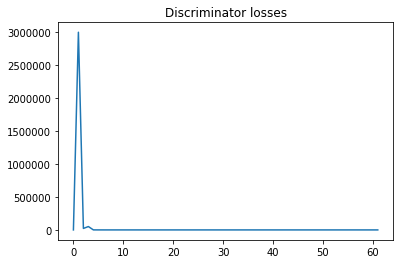

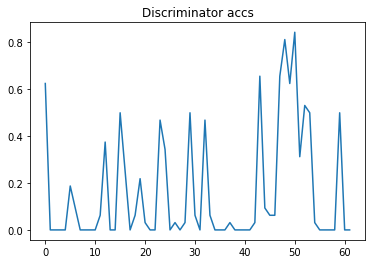

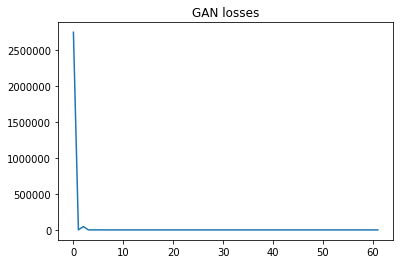

plot generated_image
epoch 2 of 500
61/62 [============================>.] - ETA: 2s
D loss: 1.0253437757492065 acc: 0.0625
A loss: 2.2802090644836426


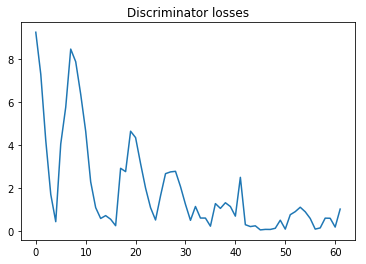

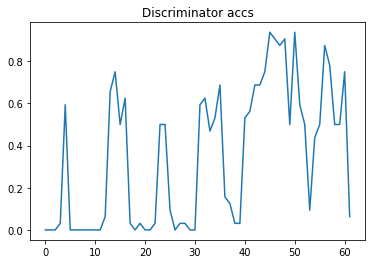

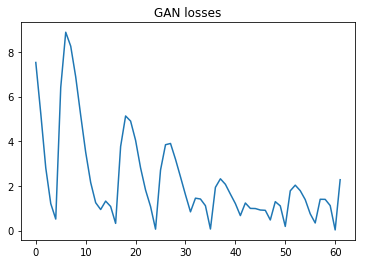

plot generated_image
epoch 3 of 500
61/62 [============================>.] - ETA: 2s
D loss: 0.13075695931911469 acc: 0.84375
A loss: 0.06315062940120697


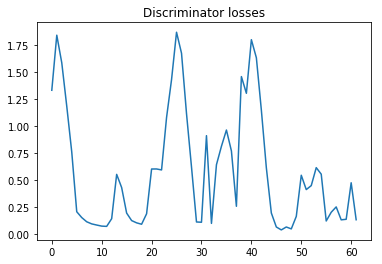

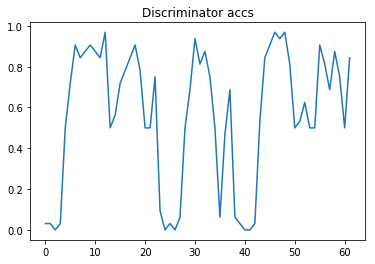

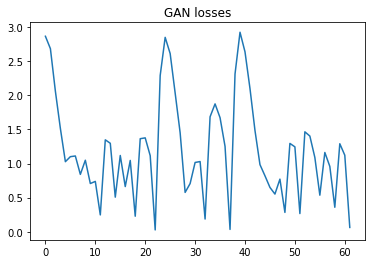

plot generated_image
epoch 4 of 500
61/62 [============================>.] - ETA: 2s
D loss: 0.10788106918334961 acc: 0.9375
A loss: 1.1006488800048828


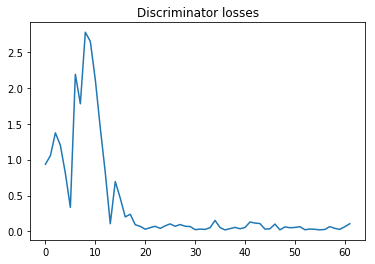

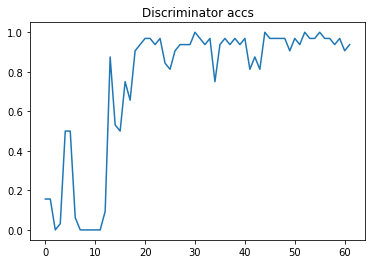

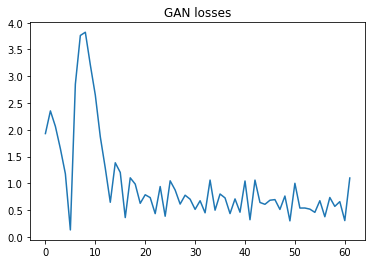

plot generated_image
epoch 5 of 500
61/62 [============================>.] - ETA: 2s
D loss: 0.05610395222902298 acc: 0.96875
A loss: 0.3616035580635071


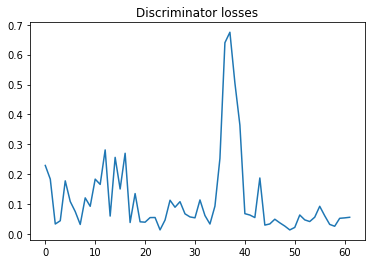

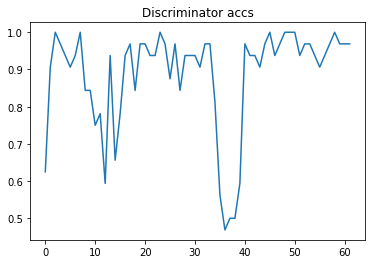

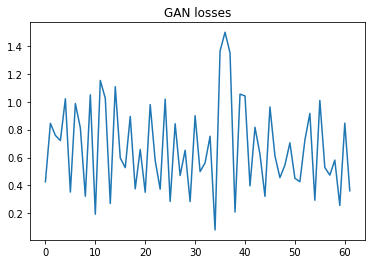

plot generated_image
epoch 6 of 500
61/62 [============================>.] - ETA: 2s
D loss: 0.07638107240200043 acc: 0.96875
A loss: 0.8874073028564453


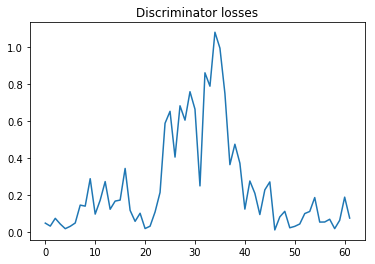

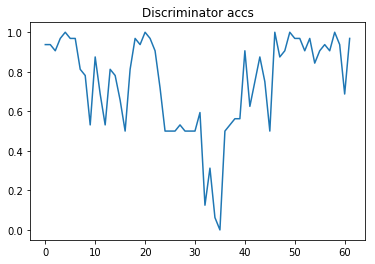

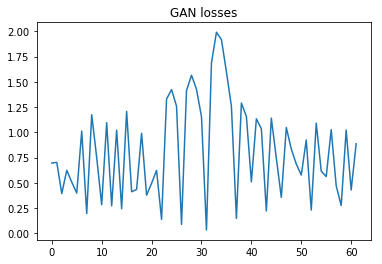

plot generated_image
epoch 7 of 500
61/62 [============================>.] - ETA: 2s
D loss: 0.031089384108781815 acc: 0.96875
A loss: 0.22851945459842682


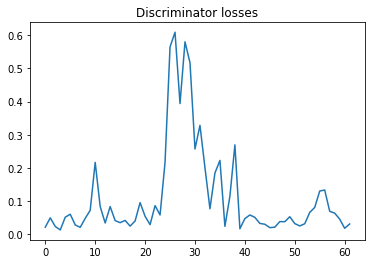

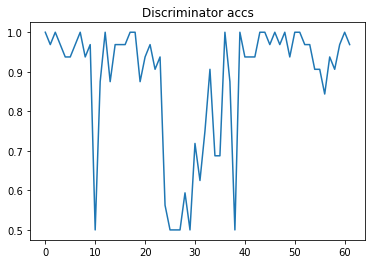

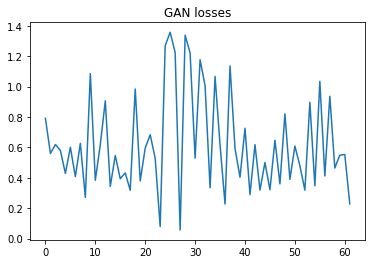

plot generated_image
epoch 8 of 500
61/62 [============================>.] - ETA: 3s
D loss: 0.11345170438289642 acc: 0.84375
A loss: 0.1419169306755066


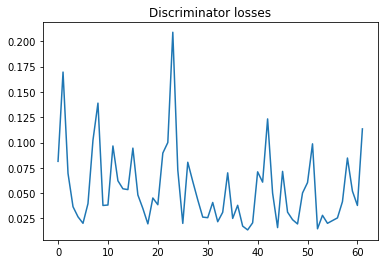

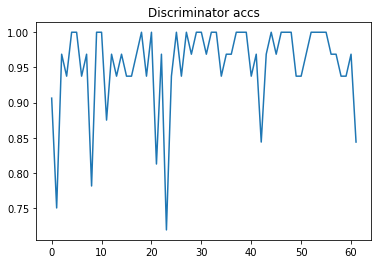

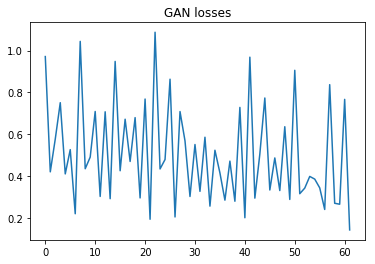

plot generated_image
epoch 9 of 500
58/62 [===========================>..] - ETA: 12s

In [ ]:
import matplotlib.pyplot as plt

for epoch in range(10):
    s = np.arange(imgs.shape[0])
    np.random.shuffle(s)
    X = imgs[s]
    Y = edges[s]


    print("epoch {} of {}".format(epoch+1, EPOCHS))
    num_batches = int(X.shape[0] // BATCHSIZE)
    #print("number of batches: {}".format(int(X.shape[0] // (BATCHSIZE))))
    progress_bar = Progbar(target=int(X.shape[0] // (BATCHSIZE * TRAINING_RATIO)))
    minibatches_size = BATCHSIZE * TRAINING_RATIO
    start_time = time()
    d_losses = []
    d_accs = []
    a_losses = []
    for index in range(int(X.shape[0] // (BATCHSIZE * TRAINING_RATIO))):
        progress_bar.update(index)
        indices = np.arange(X.shape[0])
        np.random.shuffle(indices)
        indices = indices[:BATCHSIZE]
        images_real = X[indices]
        edges_batch = Y[indices]
        #print(edges_batch.shape)
        labels_real = np.ones([BATCHSIZE,1], dtype=np.float32)
        labels_fake = np.zeros([BATCHSIZE,1], dtype=np.float32)
        
        images_fake = unet_generator.predict(edges_batch)
        train_batch = np.concatenate((images_real, images_fake))
        train_labels = np.concatenate((labels_real, labels_fake))
        batch_shuffle = np.arange(train_batch.shape[0])
        np.random.shuffle(batch_shuffle)
        train_batch = train_batch[batch_shuffle]
        train_labels = train_labels[batch_shuffle]
#         d_loss_r = discriminator.train_on_batch(images_real, labels_real)
#         d_loss_f = discriminator.train_on_batch(images_fake, labels_fake)
        d_loss = discriminator.train_on_batch(train_batch, train_labels)
        #discriminator.trainable = False
        d_losses.append(d_loss[0])
        d_accs.append(d_loss[1])
        a_loss_1 = adversarial_net.train_on_batch(edges_batch, labels_real)
        a_losses.append(a_loss_1)
        #a_loss_2 = adversarial_net.train_on_batch(edges_batch, y)
        #discriminator.trainable = True

    print()
    #print("D (loss_r,acc_r):{0} (loss_f,acc_f):{1}".format(d_loss_r, d_loss_f))
    print("D loss: {0} acc: {1}".format(d_loss[0],d_loss[1]))
    print("A loss: {0}".format(a_loss_1))
    plt.plot(d_losses)
    plt.title("Discriminator losses")
    plt.show()
    
    plt.plot(d_accs)
    plt.title("Discriminator accs")
    plt.show()
    
    plt.plot(a_losses)
    plt.title("GAN losses")
    plt.show()

    gen_imgs = unet_generator.predict(edges_batch)
    save_img(images_fake, epoch)
        
        
        

In [ ]:
save_img(unet_generator.predict(np.array([edges[0], edges[1]])), -1)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.plot([1,2,3])
plt.title("df")
plt.show()
plt.plot([1,2,3])
plt.show()